# In this notebook a sensitivity analysis will be performed. The best Automatic Trader will be trained and tested many times, with the SPY symbol, to assess the sensitivity to changes in the period chosen for training and testing.

In [6]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool
import pickle

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def show_results(results_list, data_in_df, symbol, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = symbol
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

### Let's create some training / testing pairs

In [8]:
n_train = 20

data_df = pd.read_pickle('../../data/data_df.pkl')
u_data_df = data_df.unstack()
n_samples = u_data_df.shape[0]
n_test = 504
first_test_start = n_samples - 4 * n_test
test_starts = np.linspace(first_test_start, n_samples - n_test, n_train).astype(np.int)
train_test_pairs = [(u_data_df.iloc[:test_start], u_data_df.iloc[test_start:test_start + n_test]) 
                    for test_start in test_starts]

### Just to check, let's print the shapes of the different train/test pairs

In [9]:
for data_train_df, data_test_df in train_test_pairs:
    print(data_train_df.shape)
    print(data_test_df.shape)
    print('-'*100)

(4008, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4087, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4167, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4246, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4326, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4405, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4485, 2515)
(504, 2515)
----------------------------------------------------------------------------------------------------
(4565, 2515)
(504, 2515)
---------------------------------------------------------------------------------------------

## Let's test training with SPY n_train times

In [10]:
n_train = 20

# Set the train/test pairs
n_test = 504
data_df = pd.read_pickle('../../data/data_df.pkl')
u_data_df = data_df.unstack()
n_samples = u_data_df.shape[0]
first_test_start = n_samples - 4 * n_test
test_starts = np.linspace(first_test_start, n_samples - n_test, n_train).astype(np.int)
train_test_pairs = [(u_data_df.iloc[:test_start], u_data_df.iloc[test_start:test_start + n_test]) 
                    for test_start in test_starts]

STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]

symbol = 'SPY'
print('Testing with:\n{}'.format(symbol))

# Results holder
results_df = pd.DataFrame(columns=['sharpe', 
                                   'sharpe_bench', 
                                   'cum_ret', 
                                   'cum_ret_bench', 
                                   'sharpe_quotient', 
                                   'cum_ret_quotient',])

for data_train_all_df, data_test_all_df in train_test_pairs:
    # Set the datasets to use
    total_data_train_df = data_train_all_df.stack()
    total_data_test_df = data_test_all_df.stack()
    data_train_df = data_train_all_df[symbol]
    data_test_df = data_test_all_df[symbol]
    data_in_df = data_train_df
    
    # Set the environment
    env, num_states, num_actions = sim.initialize_env(total_data_train_df, 
                                                  symbol, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
    # Create the Agent
    agent = Agent(num_states=num_states, 
                  num_actions=num_actions, 
                  random_actions_rate=0.98, 
                  random_actions_decrease=0.9999,
                  dyna_iterations=0,
                  name='Agent_0')
    
    # Train
    print('Training: {}'.format(symbol))
    n_epochs = 7

    for i in range(n_epochs):
        tic = time()
        env.reset(STARTING_DAYS_AHEAD)
        results_list = sim.simulate_period(total_data_train_df, 
                                           symbol,
                                           agent,
                                           starting_days_ahead=STARTING_DAYS_AHEAD,
                                           possible_fractions=POSSIBLE_FRACTIONS,
                                           verbose=False,
                                           other_env=env)
        toc = time()
        print('Epoch: {}'.format(i))
        print('Elapsed time: {} seconds.'.format((toc-tic)))
        print('Random Actions Rate: {}'.format(agent.random_actions_rate))
        show_results([results_list], data_in_df, symbol)
    
    
    # Test
    print('-'*100)
    print('Testing: {}'.format(symbol))
    TEST_DAYS_AHEAD = 20
    env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
    tic = time()
    results_list = sim.simulate_period(total_data_test_df, 
                                    symbol,
                                    agent,
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
    toc = time()
    
    # Show results
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agent.random_actions_rate))
    show_results([results_list], data_test_df, symbol, graph=False)
    print('-'*100)
    
    # Save some results
    total_value = results_list.sum(axis=1)
    sharpe, cumret, _, _, _ = value_eval(pd.DataFrame(total_value))
    sharpe_bench, cumret_bench, _, _, _ = value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))
    sharpe_q = sharpe / sharpe_bench
    cumret_q = cumret / cumret_bench
    results_df = results_df.append(pd.DataFrame({symbol: {'sharpe': sharpe,
                                         'sharpe_bench': sharpe_bench,
                                         'cum_ret': cumret,
                                         'cum_ret_bench': cumret_bench,
                                         'sharpe_quotient': sharpe_q,
                                         'cum_ret_quotient': cumret_q}}).T)

Testing with:
SPY
Training: SPY
Starting simulation for agent: Agent_0. 3756 days of simulation to go.
Date 2008-12-18 00:00:00 (simulating until 2008-12-24 00:00:00).  Time: 0.2952439785003662s.  Value: 11871.040000000075.Epoch: 0
Elapsed time: 83.10213375091553 seconds.
Random Actions Rate: 0.6731941654656789
Sharpe ratio: 0.14088576754400703
Cum. Ret.: 0.15990200000000754
AVG_DRET: 8.104422778576851e-05
STD_DRET: 0.009131775721125442
Final value: 11599.020000000075
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 3756 days of simulation to go.
Date 2008-12-18 00:00:00 (simulating until 2008-12-24 00:00:00).  Time: 0.25066304206848145s.  Value: 51112.59000000006.Epoch: 1
Elapsed time: 82.40637874603271 seconds.
Random Actions Rate: 0.462439167772485
Sharpe ratio: 0.8542045263385797
Cum. Ret.: 4.058429000000006
AVG_DRET: 0.0004696130417083821
STD_DRET: 0.008727272795792955
Final value: 50584.29

In [11]:
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient
SPY,0.101345,0.488584,0.207426,0.420780,1.047845,0.401566
SPY,0.308724,0.471219,0.655161,1.249197,1.267268,0.985740
SPY,0.041099,0.140276,0.292986,0.236686,0.467989,0.505751
SPY,-0.004319,0.105701,-0.040861,0.044509,0.357456,0.124515
SPY,0.013850,0.202008,0.068562,0.119874,0.573396,0.209060
SPY,-0.067770,0.285350,-0.237498,-0.305075,0.785689,-0.388290
SPY,-0.064417,0.120515,-0.534515,-0.291462,0.410339,-0.710296
SPY,-0.001396,0.176189,-0.007923,0.046436,0.546393,0.084986
SPY,0.210130,0.395566,0.531214,1.012230,1.045023,0.968620
SPY,0.068235,0.467438,0.145976,0.594132,1.606871,0.369744


In [12]:
results_df['sharpe_delta'] = results_df['sharpe'] - results_df['sharpe_bench']
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient,sharpe_delta
SPY,0.101345,0.488584,0.207426,0.420780,1.047845,0.401566,-0.627066
SPY,0.308724,0.471219,0.655161,1.249197,1.267268,0.985740,-0.018071
SPY,0.041099,0.140276,0.292986,0.236686,0.467989,0.505751,-0.231303
SPY,-0.004319,0.105701,-0.040861,0.044509,0.357456,0.124515,-0.312948
SPY,0.013850,0.202008,0.068562,0.119874,0.573396,0.209060,-0.453522
SPY,-0.067770,0.285350,-0.237498,-0.305075,0.785689,-0.388290,-1.090764
SPY,-0.064417,0.120515,-0.534515,-0.291462,0.410339,-0.710296,-0.701801
SPY,-0.001396,0.176189,-0.007923,0.046436,0.546393,0.084986,-0.499958
SPY,0.210130,0.395566,0.531214,1.012230,1.045023,0.968620,-0.032793
SPY,0.068235,0.467438,0.145976,0.594132,1.606871,0.369744,-1.012740


In [13]:
delta = results_df['sharpe_delta']
pd.DataFrame(delta.describe())

,sharpe_delta
count,20.000000
mean,-0.403402
std,0.460441
min,-1.146399
25%,-0.742050
50%,-0.357618
75%,-0.012568
max,0.215397


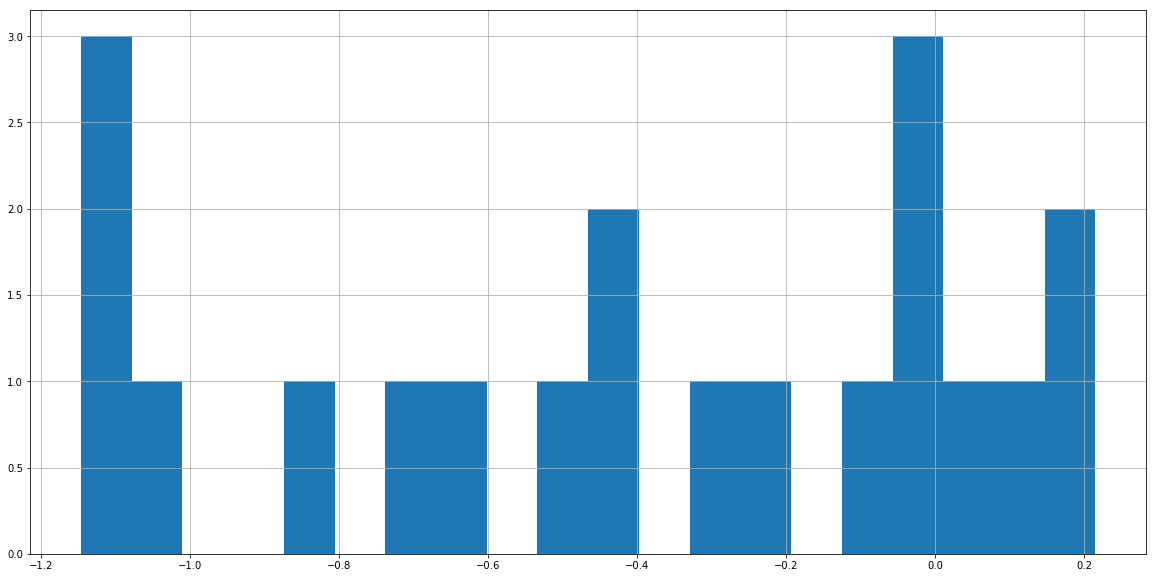

In [14]:
delta.hist(bins=20)

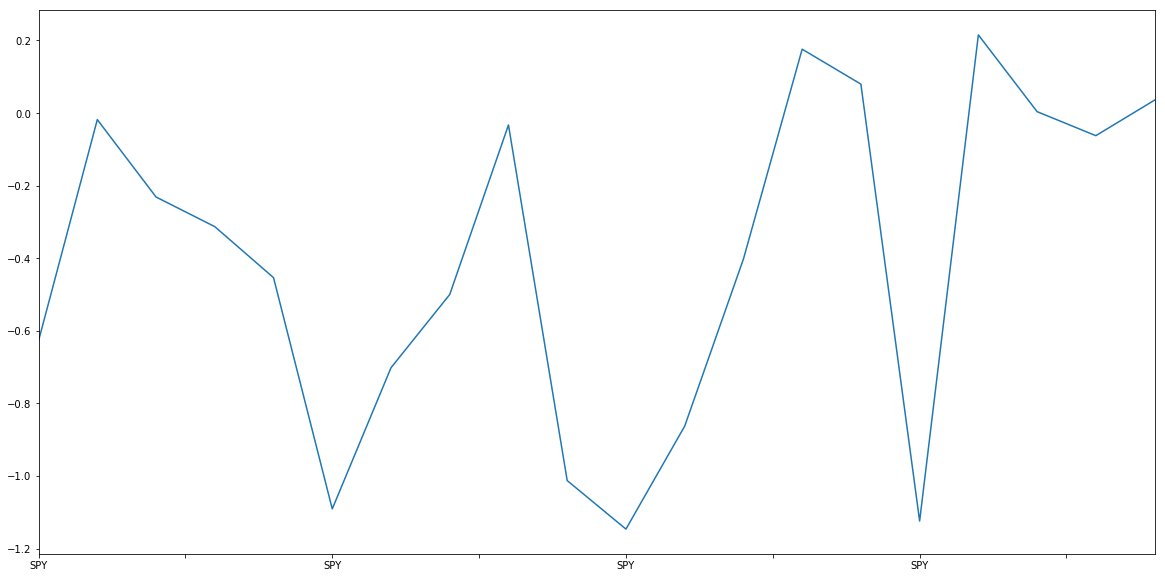

In [15]:
results_df['sharpe_delta'].plot()